# Word2vec only with one matrix

Choose CBOW/Skip-Gram again. Implement it, but now without second `h_dim x vocab_size` matrix. Remember what was the loss function in Stanford lecture.

$$ L = - \frac{1}{T} \sum_{t=1}^T \sum_{-m <= j <= m, j \ne 0} log P(w_{t+j}|w_{t+j-m})$$


$$ P(w_h | w_i) = \frac{exp(s(v_i, v_h))}{\sum exp(s(v_i, v_w))}$$

Where $s(x, y)$ is a similarity function. It is common to use dot-product here $s(x, y) = x^Ty$. The sum in the denominator is across all vocabulary for $P$ to be a probability distribution.

Look to this formula closer. There is no projection back to vocabulary dimension in the loss! So, we can reduce the number of parameters by the factor of two by not using the second matrix $W'$. Your new task is to code CBOW / SkipGram with this loss.

**Main idea:**

We project word vectors to some space. Next, we work with the space itself. We update projection matrix weights so that similar (in the terms of Distributional semantics) words have similar vectors in that space. We don't need to solve classification task explicitly here.

**Tip:**

Work with matrix operations and not with nn.layers / keras.layers.

**Results of this task** (the very same as in task 3):
 * trained word vectors (mention somewhere, how long it took to train)
 * plotted loss (so we can see that it has converged)
 * function to map token to corresponding word vector
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)
 * qualitative evaluations of word vectors: nearest neighbors, word analogies


**Extra:**
 * quantitative evaluation:
   * for intrinsic evaluation you can find datasets [here](https://aclweb.org/aclwiki/Analogy_(State_of_the_art))
   * for extrincis evaluation you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)



Supplementary materials:
  * [cs224n winter 2017 lecture 2 video](https://www.youtube.com/watch?v=ERibwqs9p38&list=PL3FW7Lu3i5Jsnh1rnUwq_TcylNr7EkRe6&index=2)
  * [cs224n winter 2019 lecture 1 slides](http://web.stanford.edu/class/cs224n/slides/cs224n-2019-lecture01-wordvecs1.pdf)

# Download & prepare

In [1]:
import collections
import math
import os
import random
import zipfile
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim 
import torch.nn.functional
import time
import requests
from os.path import isfile
import numpy as np
from six.moves import urllib
from six.moves import xrange
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import OrderedDict
from operator import itemgetter 
import torch.nn.functional as func
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


In [0]:
if not os.path.isfile('text8'):# downloading corpus
    with open('data.zip', 'wb') as f:
        r = requests.get('http://mattmahoney.net/dc/text8.zip')
        f.write(r.content)
    !unzip 'data.zip' 

def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        data = (f.read(f.namelist()[0]).split())
        data = list(map(lambda x: x.decode(), data))
    return data
with open('text8') as f:
    words = f.read().split()

In [0]:
voc_size = 15000
UNK_TOKEN = 'TOKEN'# для редких слов
frequency = collections.Counter(words)# словарь всех слов
freq = frequency.most_common(voc_size)# словарь частых слов
low_bound = freq[-1][1]# наименьшее количество повторений для попадания в словарь частых
vocab = [x[0] for x in freq]# список слов из словаря
vocab = [UNK_TOKEN] + vocab
word_index = {w: idx for (idx, w) in enumerate(vocab)}# слово - индекс
index_word = {idx: w for (idx, w) in enumerate(vocab)}# индекс - слово
data = []# индексы words
for word in words:
  if frequency[word] > low_bound:
    data.append(word_index[word])
  else:
    data.append(0)

In [0]:
class Batcher():
  def __init__(self, data, window_size, batch_size=20):
    self.window_size = window_size
    self.batch_size = batch_size
    self.data = data
    self.span = 2 * window_size + 1
  def make(self):
    label_ind = []
    label = []
    batch = []
    for i in range(self.batch_size):# создаем список центральных слов
      index = int(np.random.uniform(0,len(self.data)))
      if index == 0 or (len(words) - index - 1 < self.window_size):
                index = self.window_size
      label_ind.append(index)
    for ind in label_ind:# создаем их контексты
      label.append(self.data[ind])
      list_ = [i for i in range(-self.window_size, self.window_size+1) if i!=0]
      b = [self.data[ind+i] for i in list_]
      batch.append(b)
    return batch, label
def one_hot(batch, voc_size, window_size, batch_size):
  result = torch.zeros([batch_size, voc_size])
  for i,cont in enumerate(batch):
    for j in cont:
      result[i,j] = result[i,j] + 1# from each context we get one_hot vector
  return result

# Модель + обучение

In [0]:
class my_model(nn.Module):# модель
    def __init__(self, input_size, output_size):
        super().__init__()
        self.lin = nn.Linear(input_size, output_size)
        nn.init.uniform_(self.lin.weight,a=0,b=1)# инициализируем веса
    def forward(self, x):#forward : w * w -> softmax
        out = self.lin(x)
        log = torch.matmul(out.to(device=device, dtype = dtype),self.lin.weight.to(device=device, dtype=dtype))
        result = func.log_softmax(log, dim=1)
        return result

In [0]:
window_size = 3
batch_size = 200
learning_rate = 1
hidden_size = 200

In [0]:
start_time = time.clock()
loss_function = nn.CrossEntropyLoss()
model = my_model(input_size = voc_size,output_size = 200)
loss = torch.tensor(0)
batcher = Batcher(data, window_size, batch_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)#оптимизатор

In [0]:
x = []# для графика
y = []

In [9]:
start_time = time.clock()
losses = []
for epoch in range(3000):# обучение сети
  batch, label = batcher.make()
  batch_onehot = one_hot(batch, voc_size, window_size, batch_size)
  # Zero out all of the gradients for the variables which the optimizer will update.
  model.zero_grad()
  log_probs = model(batch_onehot).to(device=device, dtype=dtype)
  loss = loss_function(log_probs, torch.tensor(label, device=device, dtype=torch.long))
  # This is the backwards pass: compute the gradient of the loss with respect to each  parameter of the model.
  loss.backward()
  optimizer.step()
  losses.append(loss.item())
  if epoch % 300 == 0:
    s = 0
    for i in losses:
      s+= i
    x.append(epoch)
    y.append(s)
    print('epoch %d,' %epoch,'\tloss %lg' %s)
    print('time passed %d:' %(time.clock()-start_time))
  losses = []  

epoch 0, 	loss 49.0322
time passed 2:
epoch 300, 	loss 12.0313
time passed 29:
epoch 600, 	loss 11.0457
time passed 56:
epoch 900, 	loss 10.8728
time passed 84:
epoch 1200, 	loss 9.13402
time passed 111:
epoch 1500, 	loss 8.29334
time passed 137:
epoch 1800, 	loss 8.55753
time passed 164:
epoch 2100, 	loss 8.41103
time passed 190:
epoch 2400, 	loss 7.89046
time passed 217:
epoch 2700, 	loss 7.77276
time passed 244:


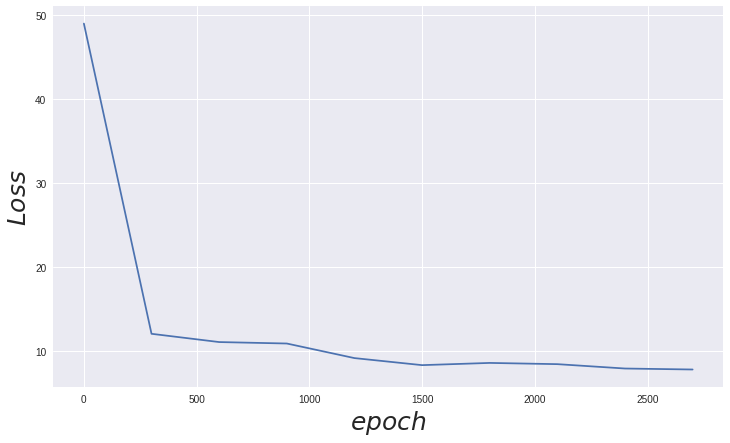

In [10]:
plt.figure(figsize=(12,7))
plt.plot(x, y)
plt.xlabel("$epoch$", fontsize=25)
plt.ylabel("$Loss$", fontsize=25)
plt.show()

# Диаграма

In [0]:
modules = enumerate(model.modules())# take first layer
next(modules)
layer = next(modules)[1]

In [0]:
def plot_with_labels(low_dim_embs, labels, filename='fig.png'):
    plt.figure(figsize=(15, 15))
    for it, label in enumerate(labels):
        x, y = low_dim_embs[it, :]
        plt.scatter(x, y)
        plt.annotate(label,xy=(x, y),xytext=(5, 2),textcoords='offset points')
    plt.savefig(filename)
def t(batch, voc_size):
  batch_onehot = torch.zeros(len(batch), voc_size)
  for i,_ in enumerate(batch):
    if type(batch[i])!= type(0):
      for y in batch[i]:
        batch_onehot[i, y] = batch_onehot[i, y] + 1
    else:
      batch_onehot[i, batch[i]] = 1
  return batch_onehot

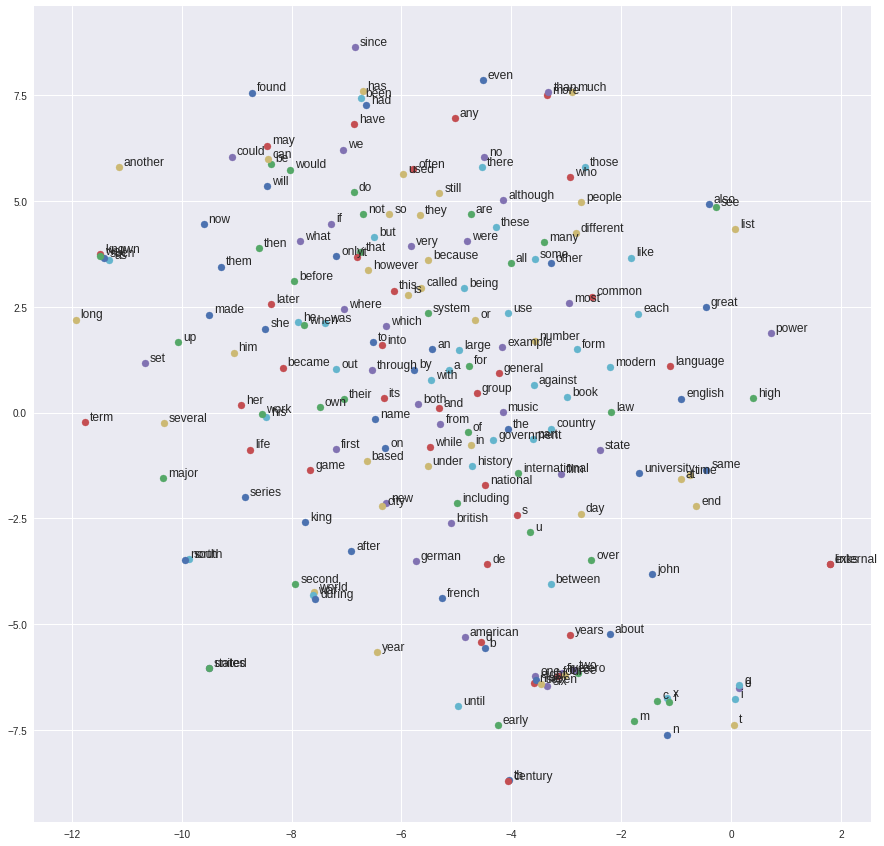

In [13]:
tsne = TSNE(n_components=2, init='pca', n_iter=10000)
plot_only = 200
final_embeddings = [layer(t([word_index[x[0]]], voc_size)).detach().numpy()[0] for x in frequency.most_common(plot_only)]
low_dim_embs = tsne.fit_transform(np.array(final_embeddings))
labels = [x[0] for x in frequency.most_common(plot_only)]
plot_with_labels(low_dim_embs, labels)

# Show words

In [0]:
def get_vector_for_word(word):#way to get a word vector
  return layer(t([word_index[word]],voc_size))

In [0]:
def cosine(w1,w2,layer):
  vec1 = get_vector_for_word(w1)
  vec2 = get_vector_for_word(w2)
  return ((vec1[0].dot(vec2[0]))/(torch.norm(vec1[0])*torch.norm(vec2[0]))).item()
def neighbours(word, vocabulary, linear, number=5):
  voc = {}# слово - кос. мера
  for i in vocabulary[0:14999]:
    voc[i[0]] = cosine(word,i[0],layer)
  voc =  OrderedDict(sorted(voc.items(), key = itemgetter(1), reverse = True))
  l = list(voc.items())
  result = []
  for i in range(1, number):
    result.append(l[i][0])
  #result = []
  #for i in range(1,number):
  #  result.append(voc[i][0])
  return result

In [16]:
print(neighbours('seven',freq, layer))

['one', 'eight', 'nine', 'four']


In [19]:
print(neighbours('king',freq, layer))

['from', 'the', 'of', 'and']


In [18]:
print(neighbours('and',freq, layer))

['the', 'in', 'of', 'with']
